<a href="https://colab.research.google.com/github/georgez7/ECS-171-Project/blob/main/Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
# @title
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [44]:
company_ticker = input("Please enter the S&P 500 company ticker name: ").upper()

Please enter the S&P 500 company ticker name: NVDA


In [45]:
# @title
# https://en.wikipedia.org/wiki/List_of_S%26P_500_companies

# Tried not to select tech companies too much
# Apple, Google, Yum brands, Visa, Intel, Ford, Costco, Pfizer
from pathlib import Path
import pandas as pd


def load_data(path):
    return pd.read_csv(Path(path))

companies = []
companies.append(company_ticker)

data = {}
# Load the data
for company in companies :
    # current dir = /content
    # data should be loaded to /content/Data/
    path = "/content/drive/Shareddrives/ECS 171/S&P 500/individual_stocks_5yr/individual_stocks_5yr/" + company + "_data.csv"

    temp = load_data(path)

    # Drop the "Name" column before adding to the data
    temp = temp.drop(['Name'], axis=1)

    #Transform Date column to datetime type for consistency
    temp['date'] = pd.to_datetime(temp['date'])
    temp.set_index('date', inplace=True)

    data[company] = temp




Data for NVDA:
              open         high          low        close        volume
count  1259.000000  1259.000000  1259.000000  1259.000000  1.259000e+03
mean     56.316546    57.071319    55.513103    56.369368  1.046580e+07
std      59.590152    60.417185    58.637797    59.624642  7.203104e+06
min      12.070000    12.290000    12.040000    12.126000  1.141128e+06
25%      18.340000    18.580000    18.170000    18.360000  6.163994e+06
50%      22.630000    22.840000    22.370000    22.670000  8.417136e+06
75%      71.345000    71.955000    70.407500    71.160000  1.202478e+07
max     245.770000   249.270000   244.450000   246.850000  9.232320e+07
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2013-02-08 to 2018-02-07
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1259 non-null   float64
 1   high    1259 non-null   float64
 2   low     1259 non-null   float64
 3   close   1259 non-null  

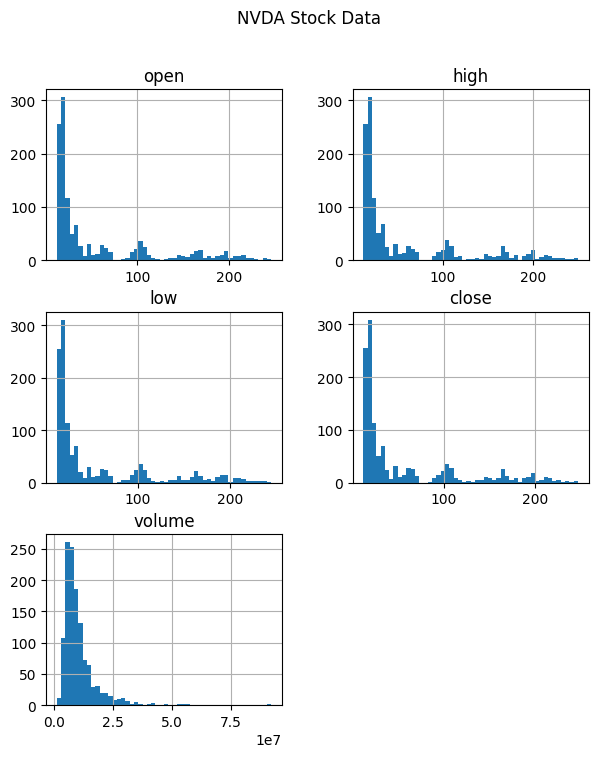

In [46]:
# @title
import matplotlib.pyplot as plt



for company_name, company_df in data.items():
    print(f"Data for {company_name}:")
    print(company_df.describe())
    print(company_df.info())

    # Histogram for each company's stock
    company_df.hist(bins=50, figsize=(7, 8))
    plt.suptitle(f"{company_name} Stock Data")  # Add the company name to the plot title
    plt.show()

NVDA has 1259 data points before processing.
NVDA has 1259 data points after processing.


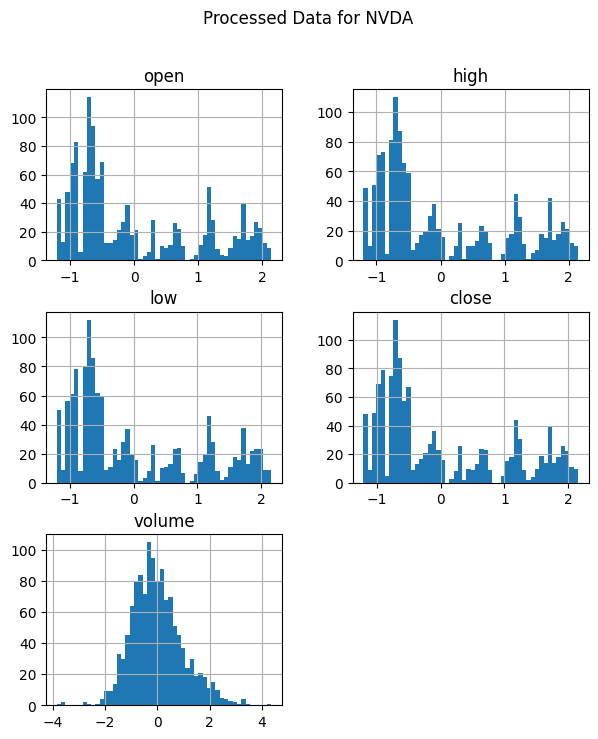

In [47]:
# @title
# Construct pipeline for preprocessing
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer


# Assuming 'data' is a dictionary of DataFrames with 'Name' dropped
data_processed = {}
transform_pipe = Pipeline([
    ("Log", FunctionTransformer(np.log, inverse_func=np.exp)),
    ("standardize", StandardScaler())
])

data_processed = {}
for company_name, comp in data.items():
    print(f"{company_name} has {len(comp)} data points before processing.")
    # process the data with the transformation pipeline
    temp = pd.DataFrame(transform_pipe.fit_transform(comp),
                        columns=comp.columns,
                        index=comp.index)

    data_processed[company_name] = temp
    print(f"{company_name} has {len(temp)} data points after processing.")



    # Visualize
    temp.hist(bins=50, figsize=(7, 8))
    plt.suptitle(f"Processed Data for {company_name}")
    plt.show()





In [48]:
# @title
# Split data into train set and test set
from sklearn.model_selection import train_test_split

train_set = {}
test_set = {}


for company_name, comp in data_processed.items():
    train_set_temp, test_set_temp = train_test_split(comp, test_size=0.2, shuffle=False)
    train_set[company_name] = train_set_temp
    test_set[company_name] = test_set_temp

# Demonstration of how to data is split up for apple
# Data from other companies should be split up in the same way
print(f"Training set for ", company_ticker, ":")
print(train_set[company_ticker].head())
print(f"Testing set for ", company_ticker, ":")
print(test_set[company_ticker].head())

Training set for  NVDA :
                open      high       low     close    volume
date                                                        
2013-02-08 -1.182961 -1.186581 -1.179267 -1.184206 -0.283215
2013-02-11 -1.173999 -1.171957 -1.173833 -1.171679  0.248676
2013-02-12 -1.180714 -1.178134 -1.171127 -1.178820 -0.470385
2013-02-13 -1.176680 -1.169321 -1.175642 -1.184206  1.624119
2013-02-14 -1.198364 -1.162756 -1.201270 -1.152275  1.686701
Testing set for  NVDA :
                open      high       low     close    volume
date                                                        
2017-02-08  1.331203  1.324392  1.328885  1.331996  0.428489
2017-02-09  1.335519  1.322060  1.321382  1.310870  1.601354
2017-02-10  1.345494  1.337270  1.292046  1.284155  2.857494
2017-02-13  1.283080  1.273579  1.247574  1.231599  2.231401
2017-02-14  1.228769  1.235576  1.227703  1.235700  1.619140


In [49]:
# @title
# Prepare Sequences

def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, :-1])  # use all features except the target variable for input
        y.append(data[i, -1])  # target is the close price
    return np.array(X), np.array(y)

n_steps = 30  # The number of timesteps per sequence

# Create sequences for each company
sequences = {}
for company_name, comp in train_set.items():
    features = comp[['open', 'high', 'low', 'volume', 'close']].values
    X, y = create_sequences(features, n_steps)
    sequences[company_name] = (X, y)

# Do the same for test sets
test_sequences = {}
for company_name, comp in test_set.items():
    features = comp[['open', 'high', 'low', 'volume', 'close']].values
    X, y = create_sequences(features, n_steps)
    test_sequences[company_name] = (X, y)




7/7 [==============================] - 1s 16ms/step


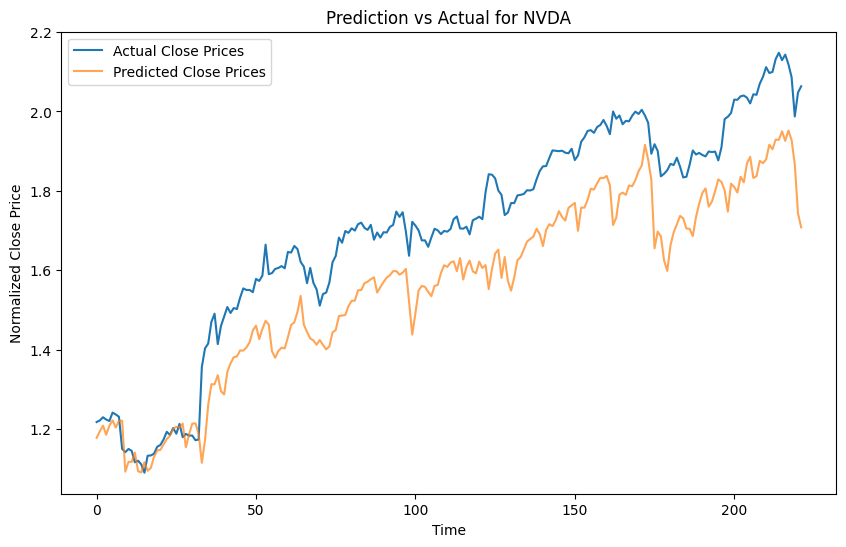

In [50]:
# @title
from tensorflow.keras.models import load_model

# Load the trained LSTM model
model = load_model('/content/drive/Shareddrives/ECS 171/best_model.h5')
# Function to predict and visualize results
def predict_and_visualize(model, company_name, X_test, y_test):
    predictions = model.predict(X_test)
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual Close Prices')
    plt.plot(predictions, label='Predicted Close Prices', alpha=0.7)
    plt.title(f'Prediction vs Actual for {company_name}')
    plt.xlabel('Time')
    plt.ylabel('Normalized Close Price')
    plt.legend()
    plt.show()

# Using the best model to predict the test data for the selected company
company_name = company_ticker  # The company name from the input
X_test, y_test = test_sequences[company_name]  # Extract test data for the company
predict_and_visualize(model, company_name, X_test, y_test)